# RNA-seq - Enrichment analysis
- goal: enrichments of DEA, DEA-clusters & time-series analysis results
- input: DEA & time-series analysis results
- output: enrichment results, summary files & plots

In [1]:
cd ../

/home/sreichl/projects/bmdm-stim


In [2]:
# libraries
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gseapy as gp

In [3]:
# import util functions
import sys
sys.path.insert(1, os.path.join('src'))

import utils_GSEApy

In [4]:
# for relaoding a module
# importlib.reload(utils_GSEApy)

In [5]:
# configs
dir_data = os.path.join('results','RNA')
dir_results=os.path.join(dir_data,'enrichment_analysis')

databases = ["ENCODE_TF_ChIP-seq_2015", # TF
             "ChEA_2016", # TF
             "BioPlanet_2019", 
             "KEGG_2019_Mouse", 
             "WikiPathways_2019_Mouse",
             "GO_Biological_Process_2021"
            ]

# more stringent adj.p-value cut-off
databases_strict=["BioPlanet_2019",
           "GO_Biological_Process_2021"]

adj_pvalue=0.05
adj_pvalue_strict=0.01

In [6]:
if not os.path.exists(dir_results):
        os.mkdir(dir_results)

# load data

In [7]:
# load filtered data
data = pd.read_csv(os.path.join(dir_data,'counts','all_filtered.tsv'), sep='\t', index_col=0, header=0,)
print(data.shape)
data.head()

(12729, 64)


,RNA_PT82_R1_LO28_24h,RNA_PT82_R2_LO28_24h,RNA_PT76_R2_LCMV_Cl13_4h,RNA_PT76_R1_LO28_6h,RNA_PT82_R2_untreated_24h,RNA_PT82_R2_IFN_beta_24h,RNA_PT76_R1_LCMV_Cl13_2h,RNA_PT76_R1_LPS_6h,RNA_PT76_R1_C_albicans_4h,RNA_PT82_R2_IFN_gamma_24h,...,RNA_PT76_R1_LCMV_Cl13_4h,RNA_PT76_R2_C_albicans_6h,RNA_PT82_R1_LPS_8h,RNA_PT76_R2_LPS_2h,RNA_PT82_R2_IFN_beta_8h,RNA_PT82_R2_LO28_8h,RNA_PT82_R1_IFN_beta_8h,RNA_PT76_R2_LPS_4h,RNA_PT76_R1_IFN_beta_6h,RNA_PT82_R2_LPS_8h
ENSMUSG00000098104,0,1,5,3,4,4,11,1,0,2,...,2,2,9,6,2,0,4,3,6,3
ENSMUSG00000033845,52,56,190,85,135,111,194,119,201,148,...,238,221,179,210,140,109,112,166,150,189
ENSMUSG00000025903,56,60,32,68,104,84,82,47,106,93,...,184,109,61,120,114,95,103,98,164,125
ENSMUSG00000033813,21,40,16,55,53,62,20,62,39,60,...,82,54,51,48,153,110,104,72,146,119
ENSMUSG00000033793,381,365,45,152,247,218,90,69,309,171,...,335,294,212,217,323,353,174,251,290,416


In [8]:
# Load sample annotation
annot = pd.read_csv(os.path.join('metadata','RNA_sample_metadata.csv'), index_col=0, header=0,)
annot = annot.loc[data.columns,:]
print(annot.shape)
annot.head()

(64, 10)


,library,timepoint after thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,organism,bio-replicate,experiment_id
RNA_PT82_R1_LO28_24h,Quant-seq,d010,BMDM,LO28,24h,PT62_c,female,mouse,R1,PT82
RNA_PT82_R2_LO28_24h,Quant-seq,d010,BMDM,LO28,24h,PT66_b,female,mouse,R2,PT82
RNA_PT76_R2_LCMV_Cl13_4h,Quant-seq,d010,BMDM,LCMV_Cl13,4h,PT66_b,female,mouse,R2,PT76
RNA_PT76_R1_LO28_6h,Quant-seq,d010,BMDM,LO28,6h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R2_untreated_24h,Quant-seq,d010,BMDM,untreated,24h,PT66_b,female,mouse,R2,PT82


In [9]:
# load gene annotation
gene_annot = pd.read_csv(os.path.join(dir_data,'counts','gene_annotation.tsv'), sep='\t', index_col=0, header=0,)
print(gene_annot.shape)
gene_annot.head()

(55487, 8)


,version,source,external_gene_name,external_gene_source,description,gene_biotype,length,gc
ensembl_gene_id,,,,,,,,
ENSMUSG00000000194,13,ensembl_havana,Gpr107,MGI Symbol,G protein-coupled receptor 107 [Source:MGI Sym...,protein_coding,12766,0.494595
ENSMUSG00000000247,11,ensembl_havana,Lhx2,MGI Symbol,LIM homeobox protein 2 [Source:MGI Symbol;Acc:...,protein_coding,4393,0.597086
ENSMUSG00000000544,14,ensembl_havana,Gpa33,MGI Symbol,glycoprotein A33 (transmembrane) [Source:MGI S...,protein_coding,2742,0.530999
ENSMUSG00000000817,10,ensembl_havana,Fasl,MGI Symbol,"Fas ligand (TNF superfamily, member 6) [Source...",protein_coding,1937,0.430563
ENSMUSG00000000889,8,ensembl_havana,Dbh,MGI Symbol,dopamine beta hydroxylase [Source:MGI Symbol;A...,protein_coding,2692,0.554978


In [10]:
#  prepare list of background genes
background = gene_annot.loc[data.index, 'external_gene_name']
background = list(set(background))
background=[str(x).upper() for x in list(background)]
print(len(background))
background[:5]

12728


['PHB2', 'ACOT2', 'SMG1', 'IMPACT', 'AP5M1']

In [11]:
treatments = list(annot['Treatment'].unique())
treatments.remove('untreated')

# Enrichment analysis

## DEA results

In [14]:
# get significant genes per treatment and time point ie group
gene_lists = dict()

for treatment in treatments:
    # load DEA analysis results per treatment
    tmp_results = pd.read_csv(os.path.join(dir_data,'DEA','DEA_'+treatment+'.tsv'), header=0, sep='\t', index_col='rn')
    for group in tmp_results['group'].unique():
        
        for direction in ['up','down']:
            if direction=='up':
                tmp_genes = tmp_results.loc[(tmp_results['adj.P.Val']<0.05) & (tmp_results['group']==group) & (tmp_results['logFC']>0), ].index.unique()
            else:
                tmp_genes = tmp_results.loc[(tmp_results['adj.P.Val']<0.05) & (tmp_results['group']==group) & (tmp_results['logFC']<0), ].index.unique()
        
            if len(tmp_genes)==0:
                continue
            
            gene_lists[group+"_"+direction] = tmp_genes

print(len(gene_lists.keys()))        
gene_lists.keys()

52


dict_keys(['LO28_24h_up', 'LO28_24h_down', 'LO28_6h_up', 'LO28_6h_down', 'LO28_2h_up', 'LO28_2h_down', 'LO28_4h_up', 'LO28_4h_down', 'LO28_8h_up', 'LO28_8h_down', 'LCMV_Cl13_2h_down', 'LCMV_Cl13_24h_up', 'LCMV_Cl13_24h_down', 'IFN_beta_24h_up', 'IFN_beta_24h_down', 'IFN_beta_2h_up', 'IFN_beta_2h_down', 'IFN_beta_4h_up', 'IFN_beta_4h_down', 'IFN_beta_6h_up', 'IFN_beta_6h_down', 'IFN_beta_8h_up', 'IFN_beta_8h_down', 'LPS_6h_up', 'LPS_6h_down', 'LPS_24h_up', 'LPS_24h_down', 'LPS_2h_up', 'LPS_2h_down', 'LPS_4h_up', 'LPS_4h_down', 'LPS_8h_up', 'LPS_8h_down', 'C_albicans_4h_up', 'C_albicans_4h_down', 'C_albicans_2h_up', 'C_albicans_2h_down', 'C_albicans_24h_up', 'C_albicans_8h_up', 'C_albicans_8h_down', 'C_albicans_6h_up', 'C_albicans_6h_down', 'IFN_gamma_24h_up', 'IFN_gamma_24h_down', 'IFN_gamma_2h_up', 'IFN_gamma_2h_down', 'IFN_gamma_6h_up', 'IFN_gamma_6h_down', 'IFN_gamma_4h_up', 'IFN_gamma_4h_down', 'IFN_gamma_8h_up', 'IFN_gamma_8h_down'])

In [15]:
# convert gene IDs to symbols, and upper-case
for key in gene_lists.keys():
    gene_lists[key] = gene_annot.loc[gene_lists[key], 'external_gene_name']
    gene_lists[key] = list(gene_lists[key])
    gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

In [ ]:
util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                  background=background, 
                  databases=databases, 
                  databases_strict=databases_strict, 
                  adj_pvalue=adj_pvalue, 
                  adj_pvalue_strict=adj_pvalue_strict, 
                  dir_results=os.path.join(dir_results,'DEA'),
                  top_n = 5
                 )

/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-26 15:35:09,792 Warning: No enrich terms using library CUSTOM46914441872384 when cutoff = 0.05


## DEG clusters

In [14]:
# configs
ks = list(range(4,13))
ks

[4, 5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
for k in ks:
    # get DEG cluster genes
    gene_lists = dict()

    # load clustering results
    DEA_cluster_results = pd.read_csv(os.path.join(dir_data,'DEA','Pairs_Clusters_HM_{}'.format(k),'Genes.tsv'), header=0, sep='\t', index_col='rn')
    # make gene lists
    tmp_gene_lists=DEA_cluster_results.groupby('value')['external_gene_name'].apply(list).to_dict()

    # rename gene_lists
    for key in tmp_gene_lists.keys():
        gene_lists["cluster_"+str(key)] = tmp_gene_lists[key]

    print(len(gene_lists.keys()))        
    print(gene_lists.keys())

    # convert to upper-case
    for key in gene_lists.keys():
        gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

    util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                      background=background, 
                      databases=databases, 
                      databases_strict=databases_strict, 
                      adj_pvalue=adj_pvalue, 
                      adj_pvalue_strict=adj_pvalue_strict, 
                      dir_results=os.path.join(dir_results,'DEG_clusters','k_{}'.format(k)),
                  top_n = 25
                     )

11
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-29 10:59:21,060 Warning: No enrich terms using library CUSTOM46914441901248 when cutoff = 0.05
2021-11-29 11:07:27,205 Warning: No enrich terms using library CUSTOM46914441901248 when cutoff = 0.05


ChEA_2016
ENCODE_TF_ChIP-seq_2015 110
ChEA_2016 320


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


12
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-29 11:28:13,484 Warning: No enrich terms using library CUSTOM46914765253824 when cutoff = 0.05
2021-11-29 11:35:50,416 Warning: No enrich terms using library CUSTOM46914765253824 when cutoff = 0.05
2021-11-29 11:39:53,229 Warning: No enrich terms using library CUSTOM46914765253824 when cutoff = 0.05


ChEA_2016


2021-11-29 11:42:38,217 Warning: No enrich terms using library CUSTOM46914554212544 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 110
ChEA_2016 320


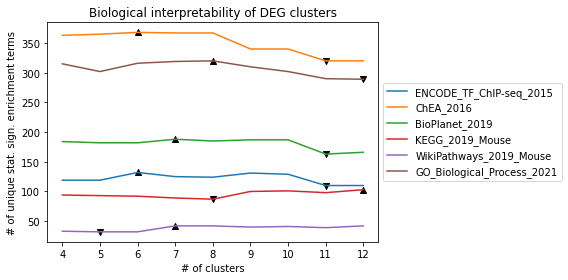

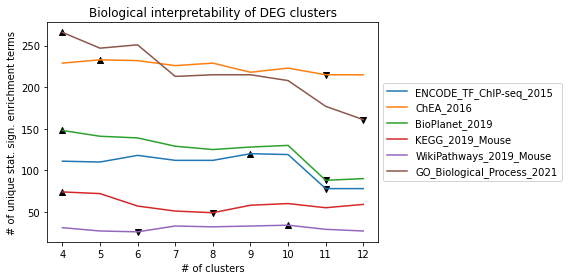

In [15]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
plot_sum_df = pd.DataFrame(index=ks, columns=databases)
plot_unique_df = pd.DataFrame(index=ks, columns=databases)

for k in ks:
    for db in databases:
        tmp_results = pd.read_csv(os.path.join(dir_results,'DEG_clusters','k_{}'.format(k), "summary_{}_adjpvalues.csv".format(db)), index_col=0)
        plot_sum_df.loc[k,db]=tmp_results.shape[0]
        plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)

# make sum plot
plot_sum_df= plot_sum_df.apply(pd.to_numeric)
plot_sum_df.plot.line(figsize=(8,4))
plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(dir_results,'DEG_clusters',"Biological_interpretability_sum.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# make unique plot
plot_unique_df= plot_unique_df.apply(pd.to_numeric)
plot_unique_df.plot.line(figsize=(8,4))
plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(dir_results,'DEG_clusters',"Biological_interpretability_unique.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## time-series clusters

In [12]:
# config
ks = list(range(2,11))#+[15,20]
ks

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
# get significant genes per treatment and per k clustering
for treatment in treatments:
    for k in ks:
        print("{}_{}".format(treatment,k))

        gene_lists = dict()
        # load clustering result
        tmp_results = pd.read_csv(os.path.join(dir_data,'time_series',treatment, "k_{}".format(k), "clustering_"+treatment+".csv"), header=0, index_col=0)
        # make gene lists
        tmp_gene_lists=tmp_results.groupby('2')['1'].apply(list).to_dict()

        # rename gene_lists
        for key in tmp_gene_lists.keys():
            gene_lists["cluster_"+str(key)] = tmp_gene_lists[key]

        # convert to upper-case
        for key in gene_lists.keys():
            gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

        print(len(gene_lists.keys()))        
        print(gene_lists.keys())

        util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                          background=background, 
                          databases=databases, 
                          databases_strict=databases_strict, 
                          adj_pvalue=adj_pvalue, 
                          adj_pvalue_strict=adj_pvalue_strict, 
                          dir_results=os.path.join(dir_results,'time_series',treatment, 'k_{}'.format(k)),
                  top_n = 25
                         )

C_albicans_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015
ChEA_2016
ENCODE_TF_ChIP-seq_2015 50
ChEA_2016 289


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


C_albicans_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:26:35,576 Warning: No enrich terms using library CUSTOM46914764249920 when cutoff = 0.05


ChEA_2016
ENCODE_TF_ChIP-seq_2015 60
ChEA_2016 280
C_albicans_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:30:03,639 Warning: No enrich terms using library CUSTOM46914764308992 when cutoff = 0.05


ChEA_2016
ENCODE_TF_ChIP-seq_2015 41
ChEA_2016 237
C_albicans_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:33:38,166 Warning: No enrich terms using library CUSTOM46914784134272 when cutoff = 0.05
2021-11-30 16:34:11,975 Warning: No enrich terms using library CUSTOM46914784134272 when cutoff = 0.05


ChEA_2016
ENCODE_TF_ChIP-seq_2015 41
ChEA_2016 233
C_albicans_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:37:40,181 Warning: No enrich terms using library CUSTOM46914801096896 when cutoff = 0.05
2021-11-30 16:37:54,799 Warning: No enrich terms using library CUSTOM46914801096896 when cutoff = 0.05


ChEA_2016


2021-11-30 16:38:44,143 Warning: No enrich terms using library CUSTOM46914897401088 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 35
ChEA_2016 216
C_albicans_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:41:37,644 Warning: No enrich terms using library CUSTOM46914761828544 when cutoff = 0.05
2021-11-30 16:41:51,944 Warning: No enrich terms using library CUSTOM46914761828544 when cutoff = 0.05
2021-11-30 16:42:27,228 Warning: No enrich terms using library CUSTOM46914761828544 when cutoff = 0.05


ChEA_2016


2021-11-30 16:42:50,985 Warning: No enrich terms using library CUSTOM46914693813504 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 32
ChEA_2016 197
C_albicans_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:45:40,360 Warning: No enrich terms using library CUSTOM46914772536192 when cutoff = 0.05
2021-11-30 16:46:26,230 Warning: No enrich terms using library CUSTOM46914772536192 when cutoff = 0.05
2021-11-30 16:46:39,178 Warning: No enrich terms using library CUSTOM46914772536192 when cutoff = 0.05
2021-11-30 16:46:47,234 Warning: No enrich terms using library CUSTOM46914772536192 when cutoff = 0.05


ChEA_2016


2021-11-30 16:47:24,307 Warning: No enrich terms using library CUSTOM46914689889600 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 44
ChEA_2016 199
C_albicans_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:50:03,510 Warning: No enrich terms using library CUSTOM46914755777472 when cutoff = 0.05
2021-11-30 16:50:45,903 Warning: No enrich terms using library CUSTOM46914755777472 when cutoff = 0.05
2021-11-30 16:50:58,835 Warning: No enrich terms using library CUSTOM46914755777472 when cutoff = 0.05
2021-11-30 16:51:06,859 Warning: No enrich terms using library CUSTOM46914755777472 when cutoff = 0.05
2021-11-30 16:51:16,175 Warning: No enrich terms using library CUSTOM46914755777472 when cutoff = 0.05


ChEA_2016


2021-11-30 16:51:43,075 Warning: No enrich terms using library CUSTOM46914686570624 when cutoff = 0.05
2021-11-30 16:51:45,152 Warning: No enrich terms using library CUSTOM46914686570624 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 44
ChEA_2016 205
C_albicans_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 16:54:10,752 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05
2021-11-30 16:54:40,294 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05
2021-11-30 16:54:40,796 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05
2021-11-30 16:54:53,767 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05
2021-11-30 16:55:01,893 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05
2021-11-30 16:55:11,073 Warning: No enrich terms using library CUSTOM46914830578048 when cutoff = 0.05


ChEA_2016


2021-11-30 16:55:46,985 Warning: No enrich terms using library CUSTOM46914681825920 when cutoff = 0.05
2021-11-30 16:55:49,083 Warning: No enrich terms using library CUSTOM46914681825920 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 46
ChEA_2016 200
IFN_gamma_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015
ChEA_2016
ENCODE_TF_ChIP-seq_2015 16
ChEA_2016 140
IFN_gamma_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015
ChEA_2016
ENCODE_TF_ChIP-seq_2015 14
ChEA_2016 136
IFN_gamma_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015
ChEA_2016


2021-11-30 17:10:19,764 Warning: No enrich terms using library CUSTOM46914668469696 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 13
ChEA_2016 134
IFN_gamma_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015
ChEA_2016


2021-11-30 17:16:22,453 Warning: No enrich terms using library CUSTOM46914973603648 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 8
ChEA_2016 104
IFN_gamma_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 17:21:47,056 Warning: No enrich terms using library CUSTOM46915053468416 when cutoff = 0.05


ChEA_2016


2021-11-30 17:22:59,562 Warning: No enrich terms using library CUSTOM46915149653568 when cutoff = 0.05
2021-11-30 17:23:22,967 Warning: No enrich terms using library CUSTOM46915149653568 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 10
ChEA_2016 103
IFN_gamma_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 17:26:27,091 Warning: No enrich terms using library CUSTOM46914758170240 when cutoff = 0.05
2021-11-30 17:27:06,621 Warning: No enrich terms using library CUSTOM46914758170240 when cutoff = 0.05
2021-11-30 17:28:21,168 Warning: No enrich terms using library CUSTOM46914758170240 when cutoff = 0.05
2021-11-30 17:29:00,274 Warning: No enrich terms using library CUSTOM46914758170240 when cutoff = 0.05


ChEA_2016


2021-11-30 17:30:18,629 Warning: No enrich terms using library CUSTOM46914665260480 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 8
ChEA_2016 87
IFN_gamma_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 17:33:46,197 Warning: No enrich terms using library CUSTOM46914886186496 when cutoff = 0.05
2021-11-30 17:34:58,708 Warning: No enrich terms using library CUSTOM46914886186496 when cutoff = 0.05
2021-11-30 17:35:43,826 Warning: No enrich terms using library CUSTOM46914886186496 when cutoff = 0.05


ChEA_2016


2021-11-30 17:37:28,210 Warning: No enrich terms using library CUSTOM46914987909440 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 6
ChEA_2016 98
IFN_gamma_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 17:41:14,142 Warning: No enrich terms using library CUSTOM46914789566912 when cutoff = 0.05
2021-11-30 17:41:40,591 Warning: No enrich terms using library CUSTOM46914789566912 when cutoff = 0.05
2021-11-30 17:42:10,013 Warning: No enrich terms using library CUSTOM46914789566912 when cutoff = 0.05


ChEA_2016


2021-11-30 17:45:06,306 Warning: No enrich terms using library CUSTOM46914651716224 when cutoff = 0.05
2021-11-30 17:45:18,079 Warning: No enrich terms using library CUSTOM46914651716224 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 6
ChEA_2016 150
IFN_gamma_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ENCODE_TF_ChIP-seq_2015


2021-11-30 17:49:01,030 Warning: No enrich terms using library CUSTOM46915059757248 when cutoff = 0.05
2021-11-30 17:49:28,761 Warning: No enrich terms using library CUSTOM46915059757248 when cutoff = 0.05
2021-11-30 17:49:57,287 Warning: No enrich terms using library CUSTOM46915059757248 when cutoff = 0.05
2021-11-30 17:52:21,855 Warning: No enrich terms using library CUSTOM46915059757248 when cutoff = 0.05


ChEA_2016


2021-11-30 17:53:22,462 Warning: No enrich terms using library CUSTOM46915157769152 when cutoff = 0.05
2021-11-30 17:53:33,130 Warning: No enrich terms using library CUSTOM46915157769152 when cutoff = 0.05
2021-11-30 17:54:13,098 Warning: No enrich terms using library CUSTOM46915157769152 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 6
ChEA_2016 136


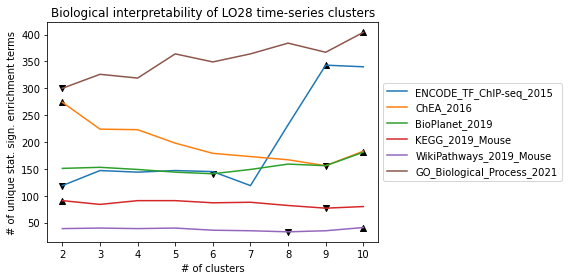

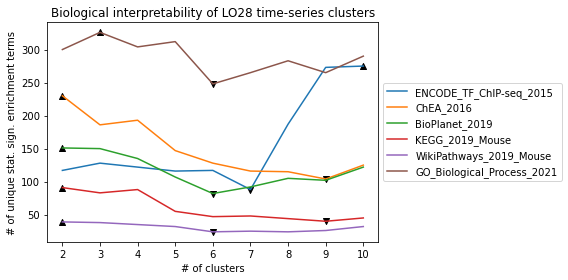

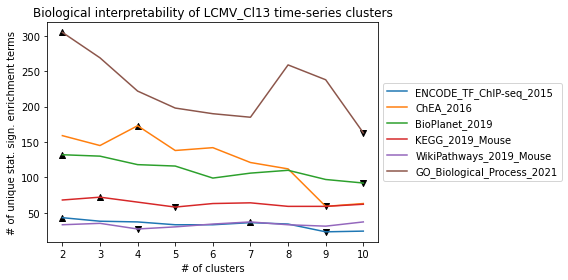

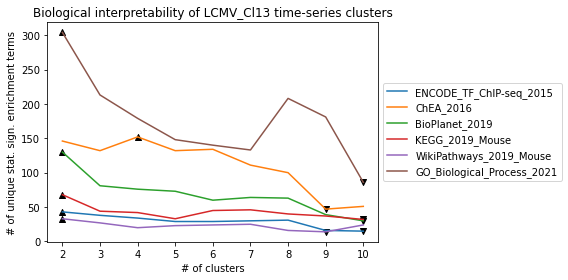

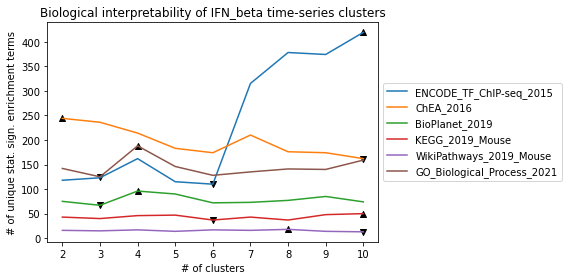

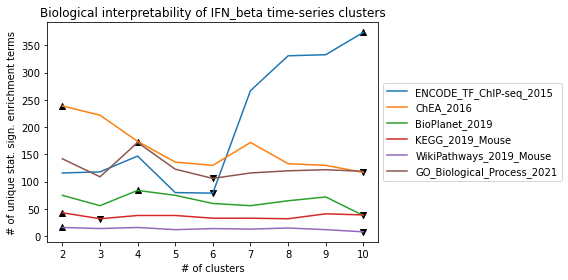

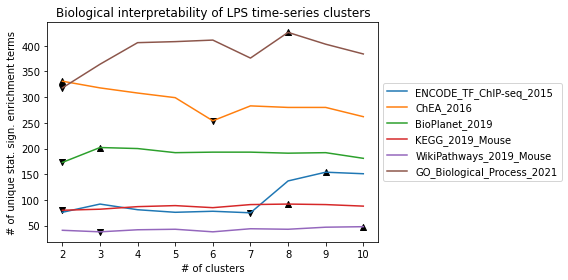

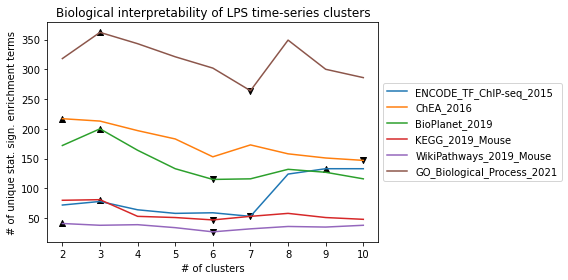

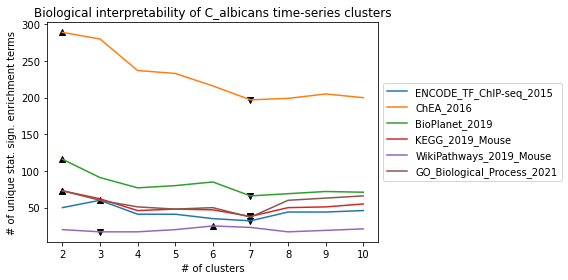

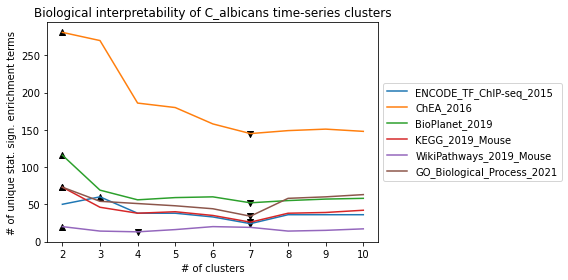

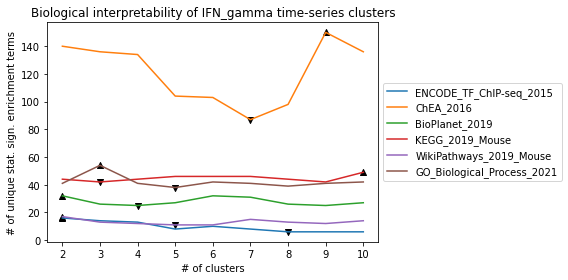

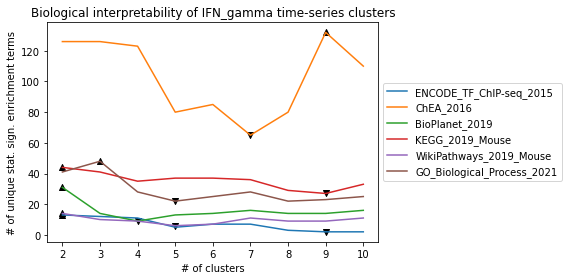

In [22]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
for treatment in treatments:
    plot_sum_df = pd.DataFrame(index=ks, columns=databases)
    plot_unique_df = pd.DataFrame(index=ks, columns=databases)
    for k in ks:
        for db in databases:
            tmp_results = pd.read_csv(os.path.join(dir_results,'time_series',treatment,"k_{}".format(k), "summary_{}_adjpvalues.csv".format(db)), index_col=0)
            plot_sum_df.loc[k,db]=tmp_results.shape[0]
            plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)
    
    # make sum plot
    plot_sum_df= plot_sum_df.apply(pd.to_numeric)
    plot_sum_df.plot.line(figsize=(8,4))
    plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
    plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(dir_results,'time_series',treatment,"Biological_interpretability_sum_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    
    # make unique plot
    plot_unique_df= plot_unique_df.apply(pd.to_numeric)
    plot_unique_df.plot.line(figsize=(8,4))
    plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
    plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(dir_results,'time_series',treatment,"Biological_interpretability_unique_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()